In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

BASE_DIR = os.getcwd().rpartition('/')[0]

In [2]:
features_df = pd.read_csv(BASE_DIR + "/Data/features.csv")
features_df.drop_duplicates(inplace=True)

labels_df = pd.read_csv(BASE_DIR + "/Data/labels.csv")
test_df = pd.read_csv(BASE_DIR + "/Data/test.csv")


features_df = features_df.merge(labels_df, on = 'trackID')
X_train = features_df[features_df.columns[:-1]]
y_train = features_df[features_df.columns[-1]]


In [3]:
## Based on the y labels, we know we have quite an imbalanced dataset. 

features_df['genre'].value_counts()

classic pop and rock     1684
folk                     1665
metal                    1209
soul and reggae           988
punk                      981
pop                       731
dance and electronica     523
jazz and blues            347
Name: genre, dtype: int64

In [4]:
features_df.head()

## Note: there are some NaN entries within the dataframe. 
## We will take care of it in the processing pipeline later on.

,trackID,title,tags,loudness,tempo,time_signature,key,mode,duration,vect_1,...,vect_140,vect_141,vect_142,vect_143,vect_144,vect_145,vect_146,vect_147,vect_148,genre
0,6654,Beside the Yellow Line,"i, the, to, and, a, me, it, not, in, my, is, o...",-8.539,104.341,3.0,7.0,1.0,298.73587,44.462048,...,0.000302,0.000302,0.000315,0.000297,0.000305,0.000266,0.000225,0.130826,1.071914,folk
1,5883,Ooh Na Na,"i, you, to, and, a, me, it, not, in, my, is, y...",-4.326,141.969,3.0,6.0,0.0,236.09424,46.069761,...,0.001855,0.001920,0.001950,0.001937,0.001912,0.001836,0.001740,0.148765,0.882304,soul and reggae
2,3424,Calabria 2008,"i, the, you, to, and, a, me, it, not, in, of, ...",-9.637,126.003,4.0,10.0,0.0,412.94322,40.376622,...,0.001039,0.001116,0.001166,0.001159,0.001110,0.001015,0.000895,0.116206,0.306846,soul and reggae
3,5434,Verbal Abuse (Just an American Band),"i, you, to, and, a, me, it, not, my, is, your,...",-10.969,197.625,4.0,2.0,1.0,64.78322,45.598532,...,0.000284,0.000313,0.000325,0.000324,0.000299,0.000273,0.000236,0.163738,1.247803,punk
4,516,Helen Of Troy,"i, the, to, a, me, it, not, in, is, your, we, ...",-5.369,170.008,4.0,0.0,1.0,191.97342,47.159148,...,0.000927,0.000994,0.001037,0.001051,0.001011,0.000962,0.000898,0.108193,0.366419,dance and electronica


## Feature Selection

- Categorical: mode, tags (?)
    
- Linear: loudness, tempo, time_signature, duration, key, vect_1...vect_148
    
    
Since most of the ML models only accept either *categorical* OR *linear* features, I choose to utilize only the *linear* features since there is much more features and hence more information contained in them.

Word tags are generated by human annotators so there will be inconsistency in the choice of tags; Moreover, by visual observation, the tags contain a lot of stopwords (words that do not contain significant meaning) hence it makes more sense to avoid using tags altogether.

I plot the cumulative frequency distribution of some of the linear features listed below.


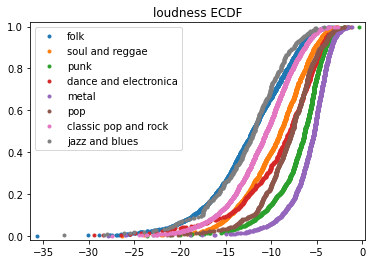

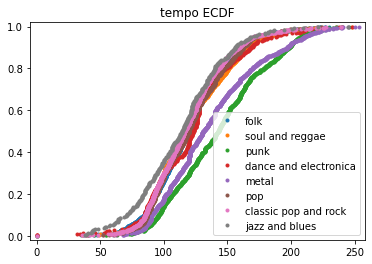

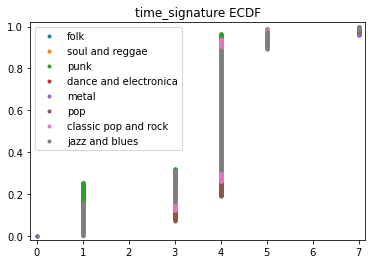

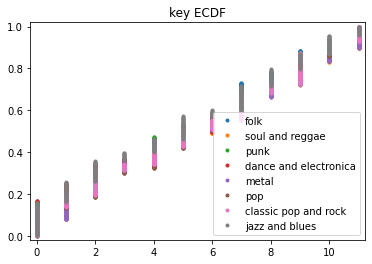

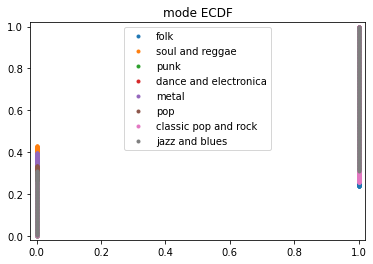

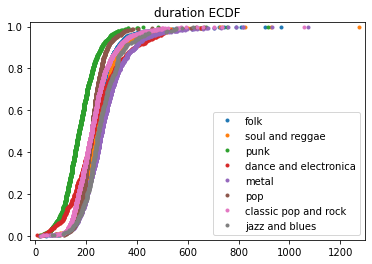

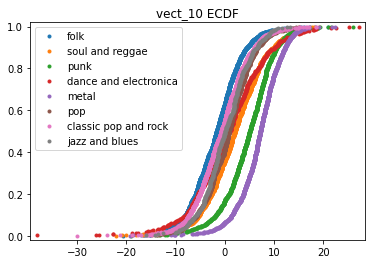

In [5]:
feature_list = ['loudness','tempo','time_signature','key','mode','duration','vect_10']
genre_list = features_df['genre'].unique().tolist()


def ecdf(data):
    x_axis = np.sort(data)
    y_axis = np.arange(1,(len(data)+1))/len(data)
    return x_axis, y_axis


## Plot ECDF of various features
for feature in feature_list:
    for genre in genre_list:
        df = features_df[features_df['genre']==genre][feature]
        x,y = ecdf(df)
        plt.plot(x,y,linestyle='none',marker='.',label=genre)
    plt.legend()
    plt.title(f"{feature} ECDF")
    plt.margins(0.02)
    plt.show()

The features values are of very different magnitudes hence they need to be scaled by either MinMaxScaler() or StandardScaler(). Outliers are quite common, hence I think the better choice is to use StandardScaler() as it anchors the Z-scores about the mean. 

In [6]:
# import sklearn functions

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report


In [7]:
def get_models():
	models, names = list(), list()
	# LogisticRegression
	models.append(LogisticRegression(max_iter=10000, tol=0.01))
	names.append('LogisticRegression')
	# LinearDiscriminantAnalysis
	models.append(LinearDiscriminantAnalysis())
	names.append('LinearDiscriminantAnalysis')
	# LinearSVC
	models.append(LinearSVC(max_iter=2000))
	names.append('LinearSVC')
	# KNeighborsClassifier_5
	models.append(KNeighborsClassifier(n_neighbors=5)) # n=5 is the default value
	names.append('KNeighborsClassifier_5')
    # RandomForestClassifier
	models.append(RandomForestClassifier(100))
	names.append('RandomForestClassifier')
    
	return models, names

# generate a list of models
models, names = get_models() 

In [8]:
# create a list of linear features & categorical features

vect_list = ['vect_'+str(i) for i in range(1,148+1)]
linear_features = ['loudness','tempo','time_signature','duration','key']
linear_features.extend(vect_list)

cat_features = ['mode']

In [9]:
for model,name in zip(models,names):
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), # this will fillna() with mean/median for all missing values in each column.
                                          ('scaler',StandardScaler() )
                                          ])
    
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, linear_features)])
    
    pca = PCA(n_components=0.95) # using PCA @ 95% variance allows to reduce # dimensions from 152 to 42 features
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                            ('pca', pca),
                          ('classifier', model)
                          ])  
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print('-' * 50)
    print(f"{name} classification report:\n{classification_report(y_train, y_pred)}")

--------------------------------------------------
LogisticRegression classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.48      0.58      0.52      1684
dance and electronica       0.54      0.31      0.40       523
                 folk       0.56      0.66      0.61      1665
       jazz and blues       0.56      0.27      0.37       347
                metal       0.83      0.86      0.85      1209
                  pop       0.45      0.31      0.37       731
                 punk       0.69      0.67      0.68       981
      soul and reggae       0.56      0.55      0.55       988

             accuracy                           0.59      8128
            macro avg       0.58      0.53      0.54      8128
         weighted avg       0.59      0.59      0.58      8128

--------------------------------------------------
LinearDiscriminantAnalysis classification report:
                       precision    recall  f1-

/Users/jeremykuek/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


--------------------------------------------------
LinearSVC classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.47      0.55      0.51      1684
dance and electronica       0.57      0.24      0.33       523
                 folk       0.53      0.70      0.61      1665
       jazz and blues       0.58      0.12      0.20       347
                metal       0.77      0.89      0.83      1209
                  pop       0.53      0.17      0.26       731
                 punk       0.65      0.64      0.64       981
      soul and reggae       0.54      0.59      0.57       988

             accuracy                           0.57      8128
            macro avg       0.58      0.49      0.49      8128
         weighted avg       0.57      0.57      0.55      8128

--------------------------------------------------
KNeighborsClassifier_5 classification report:
                       precision    recall  f1-score   suppo

# Model Selection

We observe the default model performance from 6 different ML models from the training dataset classification report shown above. The RandomForestClassifier produced a perfect score which is a obvious indication of overfitting; Thus we opt to not use it. 

Amongst the other models, the KNN model seems to outperform the rest in both accuracy and F1-score. Hence we will choose this model to be implemented for our web service.

We also note that, in general, classes with low support(count) have lower F1-scores.

# Model Pipeline Definition

In [10]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), # this will fillna() with mean/median for all missing values in each column.
                                          ('scaler',StandardScaler() ) # MinMaxScaler
                                          ])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, linear_features)])

pca = PCA(n_components=0.95) # using PCA @ 95% variance allows to reduce # dimensions from 152 to 42 features

clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('pca', pca),
                      ('classifier', KNeighborsClassifier(n_neighbors=5))
                      ])  

name = 'KNeighborsClassifier_5'

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
# print(f"{name} classification report:\n{classification_report(y_train, y_pred)}")

# Model Persistence

In [11]:
from joblib import dump, load

dump(clf, BASE_DIR+'/model_files/KNN_clf.joblib') 

['/Users/jeremykuek/Documents/GitHub/DBS_miniProject/model_files/KNN_clf.joblib']

In [12]:
# verify that model clf2 can be loaded properly and giving similar classification performance as clf

clf2 = load(BASE_DIR+'/model_files/KNN_clf.joblib') 

y_pred2 = clf2.predict(X_train)
print(f"{name} classification report:\n{classification_report(y_train, y_pred2)}")

KNeighborsClassifier_5 classification report:
                       precision    recall  f1-score   support

 classic pop and rock       0.62      0.83      0.71      1684
dance and electronica       0.81      0.46      0.59       523
                 folk       0.71      0.77      0.74      1665
       jazz and blues       0.73      0.54      0.62       347
                metal       0.92      0.90      0.91      1209
                  pop       0.67      0.64      0.65       731
                 punk       0.89      0.76      0.82       981
      soul and reggae       0.77      0.63      0.70       988

             accuracy                           0.74      8128
            macro avg       0.76      0.69      0.72      8128
         weighted avg       0.75      0.74      0.74      8128



In [17]:
clf2.predict(test_df.head(20)) # check that the classifier works on the test_df format

array(['classic pop and rock', 'metal', 'classic pop and rock',
       'classic pop and rock', 'soul and reggae', 'folk', 'metal', 'pop',
       'classic pop and rock', 'classic pop and rock', 'folk',
       'classic pop and rock', 'soul and reggae', 'classic pop and rock',
       'classic pop and rock', 'dance and electronica', 'folk',
       'classic pop and rock', 'metal', 'pop'], dtype=object)

We will proceed to implement the KNN model in a webservice in the next phase.

# Database Creation

In [14]:
# persist training dataset to database

import sqlite3 as sl

print(BASE_DIR)
conn = sl.connect(BASE_DIR+'/database/music_classification.db')

features_df.to_sql(name='Xy_train',
                   con=conn,
                   if_exists='replace',
                   #index=False
                  )


/Users/jeremykuek/Documents/GitHub/DBS_miniProject


In [15]:
trackTitle = test_df[['trackID','title']]
y_pred = clf2.predict(test_df)
y_pred = pd.Series(y_pred,name = 'pred_genre')
pd.concat([trackTitle,y_pred],axis=1) 

# observe the classification from the test dataset below

,trackID,title,pred_genre
0,6732,You Get What You Give,classic pop and rock
1,5415,Greedee,metal
2,7757,Wonderful World,classic pop and rock
3,1854,Michoacan,classic pop and rock
4,4942,HUSTLER,soul and reggae
...,...,...,...
423,186,Hablame De Frente,pop
424,4758,Jody And The Kid,classic pop and rock
425,2231,Tama,soul and reggae
426,2925,Billy Dee,folk


# Model Integration
The integration of the model into a web service is documented in the README.md file